# DESI PV Y3 Group/Cluster TFR Calibration

Using the list of groups defined by Tempel et al,  identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-cluster joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **May 27, 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

Changes I am adding:
- Adjusting cluster membership based on Tempel catalog, and updated coordinate matching cutds

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Jura Data

We already applied all of the necessary cuts when we did this calibration with the Tully Catalog, so we can just read in the file.

In [3]:
sgatab_sel=Table.read('SGA-2020_jura_Vrot_VI_ML_photocorr.fits')

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA Jura observations that have passed all quality cuts. Again, we already did this, so we can just read in the file.

In [4]:
#### Once we have already done this, we can just read in the table instead

zeroptab = Table.read('SGA-2020_jura_Vrot_VI_0ptPRIMARY_calib_z0p1.fits')

use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]

# #- Compute the absolute magnitude
# zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26'] - mu
# zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR']**2 + zeroptab['MU_ERR']**2)

# Access Tempel Cluster Catalog

These clusters come from the group catalog used by Tempel et al. in "Merging groups and clusters of galaxies from the SDSS data: the catalogue of groups and potentially merging systems", ApJ 896:3, 2020.

Cluster membership is defined using a modified friends-of-friends algorithm designed specifically for flux-limited galaxy surveys.

In [5]:
clusters = Table.read('../Tempel_catalog.fits')
clusters[:5]

recno,GalID,specID,objID,GroupID,Ngal,Rank,Dist_g,zobs,zcmb,e_zobs,Dist,Distcor,RAJ2000,DEJ2000,GLON,GLAT,SGLON,SGLAT,lambda,eta,Xpos,Ypos,Zpos,umag,gmag,rmag,imag,zmag,uMAG,gMAG,rMAG,iMAG,zMAG,k+e_u,k+e_g,k+e_r,k+e_i,k+e_z,ext_u,ext_g,ext_r,ext_i,ext_z,Lr,w,pE,pS0,pSa,pSc,Dist_e,Den1,Den2,Den4,Den8
,,,,,,,Mpc,,,,Mpc,Mpc,deg,deg,deg,deg,deg,deg,deg,deg,Mpc,Mpc,Mpc,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,1e+10solLum,,,,,,Mpc,,,,
int32,int32,int64,int64,int32,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
172087,158726,529248580003719168,1237650796215140415,44011,3,2,236.416142,0.053777464,0.054809201,8.948e-06,239.250389,236.571861,135.021058197,0.079664653,228.853230926,28.319115778,92.295801721,-55.331344049,-49.978875849,-32.376118168,181.168483,128.483486,-81.462997,17.148094,15.784389,15.125889,14.739402,14.513815,-19.7713,-21.18059,-21.881616,-22.159746,-22.457296,-0.063507,-0.017921,0.024604,-0.083753,-0.01179,0.160969,0.11844,0.085902,0.065137,0.046183,4.06113,1.189074,0.20932,0.62891,0.13168,0.03009,3.689057,74.46091273,22.02888594,6.15336723,2.51788415
327228,72110,528069903270307840,1237650796215075043,0,1,1,672.0113,0.15685776,0.157887465,1.1435e-05,672.0113,672.0113,134.857949876,0.143278881,228.695709453,28.212332979,92.059838931,-55.443978511,-50.141835547,-32.276437061,515.858261,364.136081,-229.987731,19.138816,17.918321,17.189498,16.828232,16.584034,-19.977124,-21.526771,-22.239147,-22.376838,-22.79246,-0.339275,-0.010122,-0.02657,-0.250144,-0.078721,0.151708,0.111626,0.08096,0.06139,0.043526,5.64493,3.724297,0.34157,0.21426,0.25522,0.18894,11.075921,150.42339053,21.0778816,4.64155379,1.62978187
336560,87578,528073476683098112,1237648721747837173,0,1,1,675.208141,0.1576409,0.158669701,2.4966e-05,675.208141,675.208141,134.816667883,0.304573897,228.514672952,28.260102596,91.775820196,-55.402264569,-50.182361077,-32.024357348,518.618207,366.570542,-229.275437,20.238513,18.341158,17.27582,16.851561,16.444197,-19.173203,-21.321287,-22.218917,-22.459957,-22.980149,-0.055271,0.195458,0.02775,-0.155469,-0.042641,0.148961,0.109604,0.079494,0.060278,0.042738,5.54073,3.778279,0.6838,0.16964,0.1117,0.03486,13.020945,149.78675313,21.11984227,4.6177083,1.63263866
580172,574546,528074026438912000,1237648721747836950,0,1,1,54.739215,0.011386772,0.012415323,5.996e-06,54.739215,54.739215,134.815407359,0.391638486,228.429161361,28.303819564,91.640753968,-55.361105994,-50.182987036,-31.888380828,42.044831,29.761562,-18.516568,17.019664,16.071648,15.671509,15.494102,15.344947,-16.674455,-17.626286,-18.039596,-18.203355,-18.363125,-0.024168,-0.020352,-0.007182,-0.02083,-0.010214,0.159491,0.117352,0.085113,0.064539,0.045759,0.117988,1.015138,0.06283,0.05564,0.43553,0.446,1.138717,0.93152932,0.17113515,0.72337737,0.58133401
564814,538658,529279916085110784,1237674461486841982,0,1,1,85.949506,0.018491179,0.019526456,6.014e-06,85.949506,85.949506,135.43831162,0.521885744,228.667413813,28.904815959,91.968306213,-54.753031524,-49.558899493,-31.695432369,65.413865,47.437202,-29.292589,16.60237,15.552594,15.221978,15.066548,14.938855,-18.085338,-19.127252,-19.489126,-19.607209,-19.755397,-0.025501,-0.033364,-0.002106,-0.039453,-0.018957,0.198608,0.146134,0.105988,0.080368,0.056982,0.448385,1.032792,0.00499,0.02045,0.27371,0.70085,1.998829,3.67638082,1.39720468,0.46391213,0.34032373


In [6]:
##### Let's just see how many groups/clusters we have that have at least 15 total galaxies
group_ids, counts = np.unique(clusters['GroupID'], return_counts = True)
large = counts[counts>15]
len(large)

954

# Find Group Membership
Each galaxy in the Tempel catalog is assigned to a group. So, we just need to determine which galaxies in the Tempel catalog are also in our sample.
## Match SGA galaxies to Tempel Catalog
We perform this matching in `Catalog_Matching_Tempel.ipynb`, so we can read in the file that contains the resulting objects that matched between the catalogs.

In [7]:
sgatab = Table.read('Jura_Tempel_Coordinate_Matches.fits')
print(len(sgatab))
sgatab['SGA_ID', 'RA', 'DEC', 'D26','Tempel_Group'][:5]

12255


SGA_ID,RA,DEC,D26,Tempel_Group
int64,float64,float64,float32,int32
32,212.02462598739942,62.838526399057336,0.68802845,0
38,211.66203166014844,39.52724032794356,0.41757938,67167
53,255.6410175635765,36.68179095091098,0.38201582,0
55,199.73062047638814,1.7262730115560398,0.4956815,0
63,234.87534259414386,19.697185738728333,0.6503176,0


Let's also remove all of the galaxies that were assigned to have a Tempel group of 0, as these corresponds to isolated galaxies in the Tempel catalog.

In [8]:
sgatab = sgatab[sgatab['Tempel_Group'] > 0]
print(len(sgatab))

5726


### Let's see how many large galaxy groups we have:

In [9]:
group, grp_count = np.unique(sgatab['Tempel_Group'], return_counts = True)
print('3+ galaxies:', np.sum(grp_count >= 3))
print('5+ galaxies:', np.sum(grp_count >= 5))
print('8+ galaxies:', np.sum(grp_count >= 8))
print('10+ galaxies:', np.sum(grp_count >= 10))

3+ galaxies: 51
5+ galaxies: 6
8+ galaxies: 1
10+ galaxies: 0


In [10]:
sga_groups = {
    group[i]: list(sgatab['SGA_ID'][sgatab['Tempel_Group'] == group[i]])
    for i in range(len(group))
    if grp_count[i] >= 8
}

In [11]:
for i, (cluster_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1     425   9 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

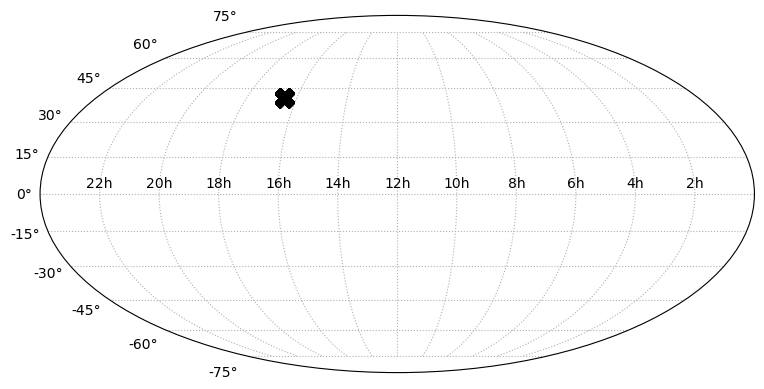

In [12]:
nest_ids = np.asarray(list(sga_groups.keys()))
idx = np.in1d(clusters['GroupID'], nest_ids)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_20241203.png', dpi=150);


In [13]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [14]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    # Get Tempel cluster members (full set)
    idx_tempel = np.in1d(clusters['GroupID'], cluster_id)
    cluster_galaxies = clusters[idx_tempel]
    cluster_coord = SkyCoord(ra=cluster_galaxies['RAJ2000'], dec=cluster_galaxies['DEJ2000'], unit='deg', frame='icrs')

    
    z_cluster = clusters['zobs'][idx_tempel]
    z_sort_tempel = np.sort(z_cluster)
    n_gal = len(z_sort_tempel)
    z_cluster_median = np.mean(z_sort_tempel[n_gal//2:n_gal//2 + 2]) if (n_gal % 2 == 0) else z_sort_tempel[n_gal//2]
    
    cluster_coords_median = cluster_median_coords(cluster_coord)

    # Get observed (SGAcat) galaxies for this cluster (subset)
    idx_sga = np.in1d(sgacat['Tempel_Group'], cluster_id)
    
    z_sga = sgacat['Z_DESI'][idx_sga]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    
    sga_subset = sgacat[idx_sga]
    sga_coords = SkyCoord(ra=sga_subset['RA'], dec=sga_subset['DEC'], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    # Calculate angular distances from cluster center for both catalogs
    separations_tempel = cluster_coord.separation(sga_coords_median)
    separations_sga = sga_coords.separation(sga_coords_median)

    # Determine max radius to cover all galaxies in both catalogs
    max_sep_tempel = np.max(separations_tempel) if len(separations_tempel) > 0 else 0
    max_sep_sga = np.max(separations_sga) if len(separations_sga) > 0 else 0
    radius = max(max_sep_tempel, max_sep_sga)

    # Plot
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=sga_coords_median, radius=1.2*radius)
    ax.grid()

    # Plot all Tempel galaxies
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, '.', color='blue',
            transform=ax.get_transform('world'), alpha=0.2, label='Tempel catalog')

    # Plot observed galaxies
    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', color='green',
            transform=ax.get_transform('world'), alpha=0.8, label='Observed (SGAcat)', zorder=10)

    # Mark cluster center and sga center
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD',
            transform=ax.get_transform('world'), ms=8, mew=2)
    ax.plot(cluster_coords_median.ra.deg, cluster_coords_median.dec.deg, 'kx',
            transform=ax.get_transform('world'), ms=8, mew=2)

    # Circle showing extent of the cluster
    circle = SphericalCircle(sga_coords_median, radius, transform=ax.get_transform('world'),
                             edgecolor='tab:green', linestyle='dashed', facecolor='none')
    ax.add_patch(circle)

    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')
    # ax.legend()


    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_cluster, cluster_coord.dec.deg, '.', color='blue', alpha=0.2, label=f'{cluster_id}')
    ax.plot(z_sga, sga_coords.dec.deg, 'o', color='green', alpha=0.8, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(z_cluster_median, cluster_coords_median.dec.deg, 'kx', ms=5, mew=5)
    
    # ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = min(np.min(cluster_coord.dec.deg), np.min(sga_coords.dec.deg) ) - 0.5
    decmax = max(np.max(cluster_coord.dec.deg), np.max(sga_coords.dec.deg) ) + 0.5

    # ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
    #                       cluster_v+3*cluster_sigma,
    #                       cluster_v-2*cluster_sigma,
    #                       cluster_v+2*cluster_sigma])/c_kms,
    #           decmin, decmax,
    #           colors='tab:blue',
    #           linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(cluster_coord.ra.deg, z_cluster, '.', color='blue', alpha=0.2, label=f'{cluster_id}')
    ax.plot(sga_coords.ra.deg, z_sga, 'o', color='green', alpha=0.8, label=f'{cluster_id}')    
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
    ax.plot(cluster_coords_median.ra.deg, z_cluster_median, 'kX', ms=5, mew=5)
    # ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = min(np.min(cluster_coord.ra.deg), np.min(sga_coords.ra.deg) ) - 0.5
    ramax = max(np.max(cluster_coord.ra.deg), np.max(sga_coords.ra.deg) ) + 0.5

    # ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
    #                       cluster_v+3*cluster_sigma,
    #                       cluster_v-2*cluster_sigma,
    #                       cluster_v+2*cluster_sigma])/c_kms,
    #           ramin, ramax,
    #           colors='tab:blue',
    #           linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.25
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    # ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
    # ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    # ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
    # ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.001
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    # ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
    # ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Jura Observations of Tempel Group {cluster_id}')

    return fig

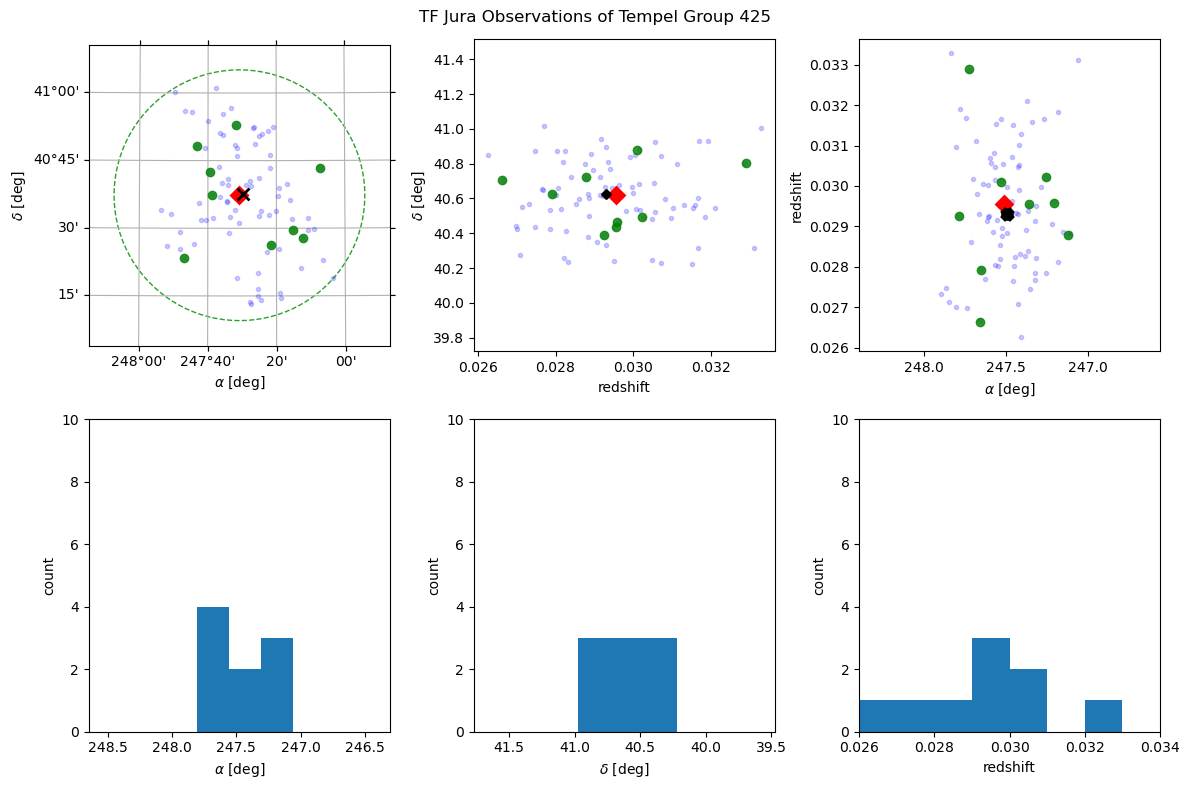

In [15]:
for cluster_id in sga_groups.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab, sga_groups[cluster_id])

# Apply Cluster Selection

Since we only have one cluster, and our sample appears to be a reasonable representation of the overall cluster, for now we are going to keep it.

# Build the Calibration Table of SGA Galaxies in Clusters

In [16]:
caltab = sgatab[sgatab['Tempel_Group'] == 425]
# for consistency, define the CLUSTER_ID to correspond to the appropriate group
caltab['CLUSTER_ID'] = caltab['Tempel_Group']
# caltab.write('SGA-2020_jura_Vrot_cluster_calib_VI_full_sample.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

CLUSTER_ID,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_err
int32,int64,float64,float64,float64,float64
425,382620,15.104577735533566,0.09233088802827866,101.81516882675562,29.938266100365432
425,633622,16.78283989774678,0.12013927061190256,60.77415655536453,1.5279967682916917
425,745318,16.17450035544494,0.09845068606879147,33.67485471882046,16.957363925120333
425,821821,14.314211531357468,0.14495340289694642,171.7272481110976,1.326040607698855
425,838741,15.052613807112538,0.12221705262499707,101.20207560521551,6.682449245430659
425,1020266,14.73845774280522,0.11037773735747572,189.79253409313534,10.484913538158706
425,1080892,14.783869998498448,0.0771009485808743,125.69156118474186,2.426805244151257
425,1353439,14.915413899097219,0.07871909207618621,138.18680035882647,3.4719209607336747
425,1362166,14.980707641957887,0.12023480077876304,95.42882410596717,13.285578965987886


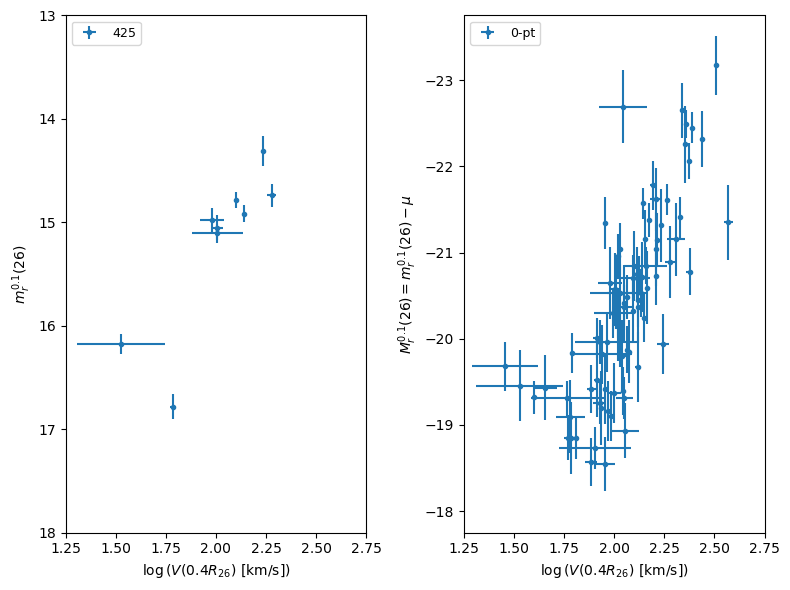

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

# #- Plot galaxies with failed cluster selections.
# _cluster_ids = np.unique(rejtab['CLUSTER_ID'])
# markers = 'sDv^<>'
# for j, _cluster_id in enumerate(_cluster_ids):
#     select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)

#     #- Store independent variable for each cluster
#     logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
#     logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data

#     #- Store dependent variable for each cluster
#     mr26 = rejtab['R_MAG_SB26_CORR'][select_cluster].data
#     mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
#     ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
#                 fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18, 13],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# # fig.savefig('Figures/TF_Y3_cluster_calibration_0pt.png', dpi=150);

# Apply the Joint TFR Fit

In [18]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])
weights.append(np.array(1/zeroptab['MAX_VOL_FRAC']))

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_cluster])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_cluster]))

logV0 = 2.0497618771745065


In [19]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -10915.275320313629
     jac: array([ 0.15770638, -0.09222276, -0.01309672,  0.06293703])
 message: 'Optimization terminated successfully.'
    nfev: 3025
     nit: 49
 success: True
       x: array([ -6.96489859, -20.2410541 ,  15.18768366,   0.69655157])
Ndim: 4 2


100%|██████████| 1000/1000 [00:02<00:00, 430.41it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [29.94106136 30.17532251 32.74473925 31.97951946] / 1637.2369623178115


100%|██████████| 1000/1000 [00:02<00:00, 444.10it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [30.7276529  41.28676224 35.10338276 31.89864745] / 2064.3381121446623


100%|██████████| 1000/1000 [00:02<00:00, 466.88it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.89568906 33.17502247 32.49288092 34.73895244] / 1736.9476221462978


100%|██████████| 1000/1000 [00:02<00:00, 459.38it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.32140078 31.75936111 35.95238744 40.55470333] / 2027.735166682681


100%|██████████| 1000/1000 [00:02<00:00, 469.58it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.98903533 34.72456884 43.01405632 40.93138701] / 2150.702816035499


100%|██████████| 1000/1000 [00:02<00:00, 463.58it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.6173476  42.11590309 42.91184091 43.03248014] / 2180.8673798521754


100%|██████████| 1000/1000 [00:02<00:00, 467.33it/s]

Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.78012551 40.36848653 41.93502857 41.71321778] / 2096.7514282515494


In [20]:
temp_outfile = open('cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_tempel.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

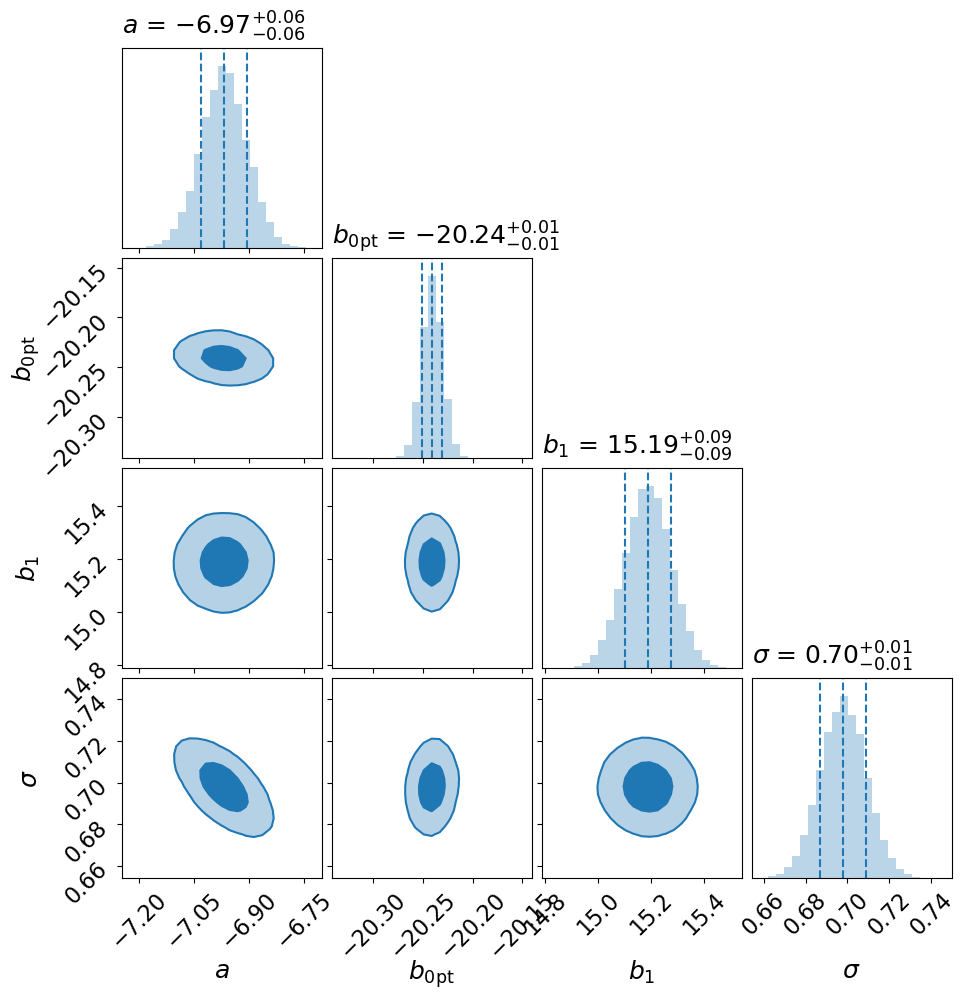

In [21]:
##### full cornerplot

labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
# fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1.png', dpi=150);

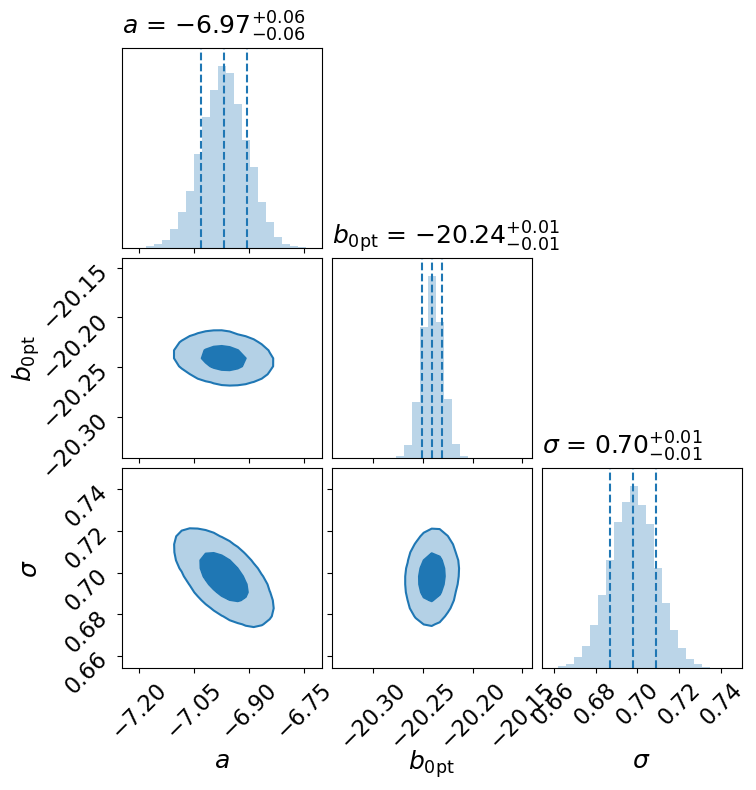

In [22]:
##### Cornerplot with just slope, zero point, and scatter
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$']
labels += [r'$\sigma$']

param_indices = [0, 1, tfr_mcmc_samples.T.shape[1] - 1]


fig = corner(tfr_mcmc_samples.T[:, param_indices], bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1_tempel.png', dpi=150);

In [23]:
# # Read in the pickle file with the fit

# # Open the pickle file and load the data
# with open('cov_ab_jura_jointTFR_varyV0_binaryML_full_sample.pickle', 'rb') as temp_infile:
#     cov_tfr, tfr_mcmc_samples, logV0 = pickle.load(temp_infile)

# # Now the variables cov_tfr, tfr_mcmc_samples, and logV0 are defined and available to use


### Plot the HyperFit Results

In [24]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

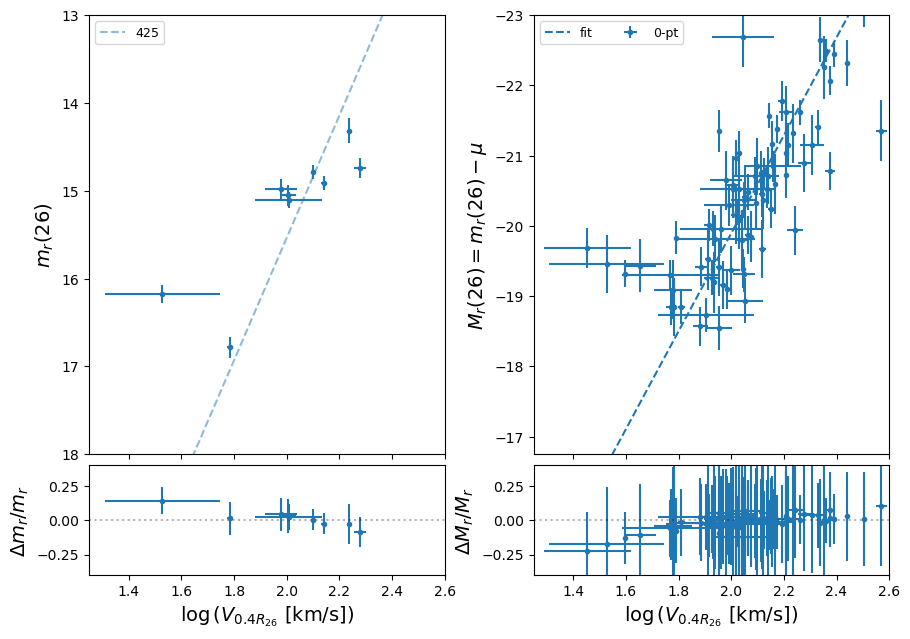

In [25]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', )
                     # label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5, label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r (26)$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--', label='fit')
ax.set(xlim=[1.25, 2.75],
       ylim=[-16.75, -23])
ax.set_ylabel(r'$M_r(26) = m_r(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('Figures/TF_Y3_cluster_calibration_0pt_binaryML_fit_full_sample.png', dpi=150)

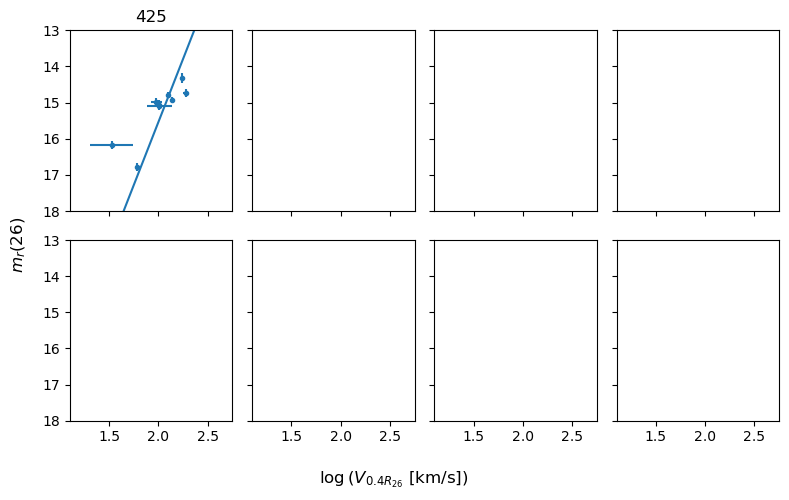

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(8,5), tight_layout=False)

color = iter(plt.get_cmap('tab20').colors)
for i in range(m):
    c = plt.get_cmap('tab20').colors[i % 20]
    
    row = int(i/4)
    col = i%4
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.1, 2.75], ylim=[18, 13], title=f'{_cluster_ids[i]}')
    
fig.supxlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r (26)$');
# plt.savefig('Figures/Y3_Individual_Cluster_Fits_full_sample.png')

## Check for Dwarf Galaxies

In [27]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

38.43381578272706 km/s


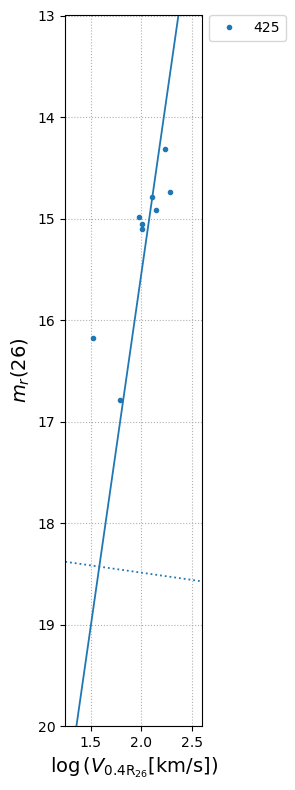

In [28]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(20, 13)

plt.gca().set_aspect('equal');

In [29]:
##### Filter out any of these dwarves

dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[i])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
